<a href="https://colab.research.google.com/github/teamgaon/KIST/blob/main/20220428_hj_lgbm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
import numpy as np
import random
import os
import math

from glob import glob
import pandas as pd
import cv2
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import torchvision.models as models
from torchvision import transforms

from matplotlib import pyplot as plt

In [41]:
train_cases = sorted(glob('/content/drive/MyDrive/KIST/open/train/*'))

In [42]:
from google.colab.patches import cv2_imshow

In [ ]:
metas = glob(train_cases[0]+'/meta/*')
metas_df = pd.concat(map(pd.read_csv, metas), ignore_index=True)

In [93]:
train_cases = glob('/content/drive/MyDrive/KIST/open/train/*')
train_cases.sort()

In [94]:
train = pd.DataFrame({'img':[0],'csv':[0],'weight':[0]})
for case in tqdm(train_cases):
  img_train = sorted(glob(case + '/image/*'))
  csv_train = sorted(glob(case + '/meta/*'))
  weights = pd.read_csv(case + '/label.csv')['leaf_weight']
  temp = pd.DataFrame({'img':img_train,'csv':csv_train,'weight':weights})
  train=pd.concat([train,temp], axis=0)
train = train[1:].reset_index(drop=True)
train

  0%|          | 0/75 [00:00<?, ?it/s]

,img,csv,weight
0,/content/drive/MyDrive/KIST/open/train/CASE01/...,/content/drive/MyDrive/KIST/open/train/CASE01/...,49.193
1,/content/drive/MyDrive/KIST/open/train/CASE01/...,/content/drive/MyDrive/KIST/open/train/CASE01/...,59.764
2,/content/drive/MyDrive/KIST/open/train/CASE01/...,/content/drive/MyDrive/KIST/open/train/CASE01/...,72.209
3,/content/drive/MyDrive/KIST/open/train/CASE01/...,/content/drive/MyDrive/KIST/open/train/CASE01/...,85.737
4,/content/drive/MyDrive/KIST/open/train/CASE01/...,/content/drive/MyDrive/KIST/open/train/CASE01/...,102.537
...,...,...,...
1587,/content/drive/MyDrive/KIST/open/train/CASE74/...,/content/drive/MyDrive/KIST/open/train/CASE74/...,211.497
1588,/content/drive/MyDrive/KIST/open/train/CASE74/...,/content/drive/MyDrive/KIST/open/train/CASE74/...,214.116
1589,/content/drive/MyDrive/KIST/open/train/CASE74/...,/content/drive/MyDrive/KIST/open/train/CASE74/...,214.293
1590,/content/drive/MyDrive/KIST/open/train/CASE75/...,/content/drive/MyDrive/KIST/open/train/CASE75/...,210.872


In [96]:
train['weight'].median()

35.0885

In [53]:
BASE_DATA_FOLDER = "/content/drive/MyDrive/KIST/open/"
TRAin_DATA_FOLDER = os.path.join(BASE_DATA_FOLDER, "train")

In [54]:
images_per_class = {}
for class_folder_name in os.listdir(TRAin_DATA_FOLDER):
    class_folder_path = os.path.join(TRAin_DATA_FOLDER, class_folder_name)
    class_label = class_folder_name
    images_per_class[class_label] = []
    for image_path in glob(os.path.join(class_folder_path, "*.png")):
        image_bgr = cv2.imread(image_path, cv2.IMREAD_COLOR)
        images_per_class[class_label].append(image_bgr)

In [47]:
def plot_for_class(label):
    nb_rows = 3
    nb_cols = 3
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(6, 6))

    n = 0
    for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            axs[i, j].xaxis.set_ticklabels([])
            axs[i, j].yaxis.set_ticklabels([])
            axs[i, j].imshow(images_per_class[label][n])
            n += 1   

In [90]:
def create_mask_for_plant(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    sensitivity = 35
    lower_hsv = np.array([60 - sensitivity, 50, 0])
    upper_hsv = np.array([60 + sensitivity, 255, 255])

    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask

def segment_plant(image):
    mask = create_mask_for_plant(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output

def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp

leaf_weight : 49.193


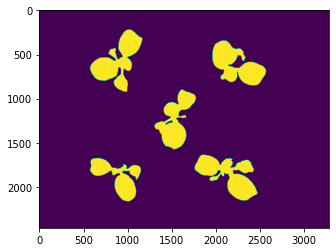

leaf_weight : 59.764


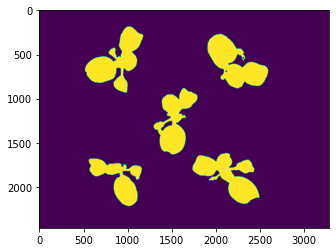

leaf_weight : 72.209


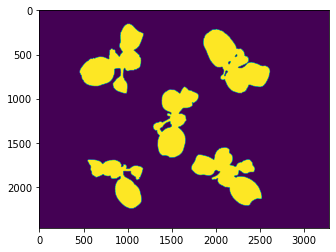

leaf_weight : 85.737


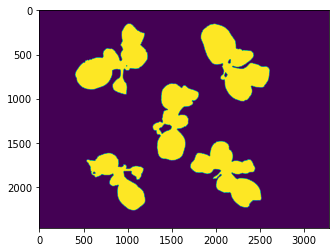

leaf_weight : 102.537


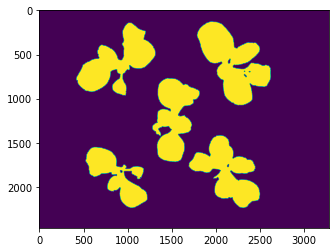

leaf_weight : 123.359


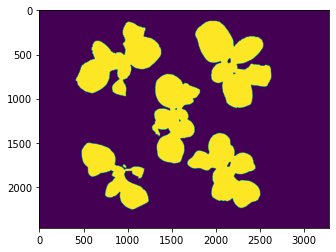

leaf_weight : 156.149


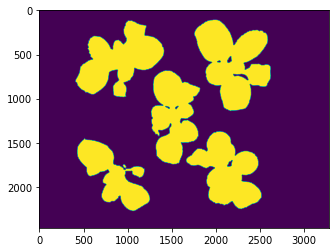

leaf_weight : 174.931


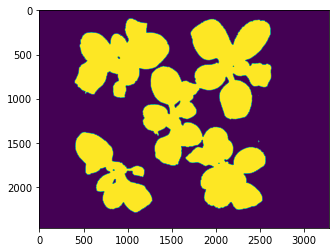

leaf_weight : 187.523


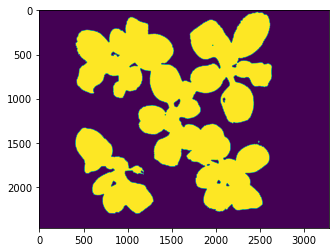

In [175]:
# Test image to see the changes
images = glob(train_cases[0]+'/image/*')
images.sort()
label = pd.read_csv(train_cases[0]+'/label.csv')
for i in range(len(images)):
  image = cv2.imread(images[i])
  image_mask = create_mask_for_plant(image)
  # image_segmented = segment_plant(image)
  # image_sharpen = sharpen_image(image_segmented)
  # print(images[i][-13:])
  print('leaf_weight : ' + str(label['leaf_weight'].loc[i]))
  # axs[0].imshow(image)
  plt.imshow(image_mask)
  # axs[2].imshow(image_segmented)
  # axs[3].imshow(image_sharpen)
  plt.show()

In [208]:
image_mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [209]:
len(np.where(image_mask>0)[0])/(len(image_mask)*len(image_mask[0])))  

0.019233672196705732

In [215]:
np.where(image_mask>0)[1]

array([2288, 2289, 2290, ..., 2044, 2045, 2046])

In [117]:
metas = glob(train_cases[0]+'/meta/*')
metas_df = pd.concat(map(pd.read_csv, metas), ignore_index=True)

In [148]:
train = pd.DataFrame({'img':[0],'csv':[0],'weight':[0]})
for case in tqdm(train_cases):
  img_train = sorted(glob(case + '/image/*'))
  csv_train = sorted(glob(case + '/meta/*'))
  weights = pd.read_csv(case + '/label.csv')['leaf_weight']
  temp = pd.DataFrame({'img':img_train,'csv':csv_train,'weight':weights})
  train=pd.concat([train,temp], axis=0)
train = train[1:].reset_index(drop=True)
train

  0%|          | 0/75 [00:00<?, ?it/s]

,img,csv,weight
0,/content/drive/MyDrive/KIST/open/train/CASE01/...,/content/drive/MyDrive/KIST/open/train/CASE01/...,49.193
1,/content/drive/MyDrive/KIST/open/train/CASE01/...,/content/drive/MyDrive/KIST/open/train/CASE01/...,59.764
2,/content/drive/MyDrive/KIST/open/train/CASE01/...,/content/drive/MyDrive/KIST/open/train/CASE01/...,72.209
3,/content/drive/MyDrive/KIST/open/train/CASE01/...,/content/drive/MyDrive/KIST/open/train/CASE01/...,85.737
4,/content/drive/MyDrive/KIST/open/train/CASE01/...,/content/drive/MyDrive/KIST/open/train/CASE01/...,102.537
...,...,...,...
1587,/content/drive/MyDrive/KIST/open/train/CASE74/...,/content/drive/MyDrive/KIST/open/train/CASE74/...,211.497
1588,/content/drive/MyDrive/KIST/open/train/CASE74/...,/content/drive/MyDrive/KIST/open/train/CASE74/...,214.116
1589,/content/drive/MyDrive/KIST/open/train/CASE74/...,/content/drive/MyDrive/KIST/open/train/CASE74/...,214.293
1590,/content/drive/MyDrive/KIST/open/train/CASE75/...,/content/drive/MyDrive/KIST/open/train/CASE75/...,210.872


In [169]:
df_3 = pd.DataFrame()

for row in train['csv']:
  df_1 = pd.read_csv(row)
  df_1 = df_1.drop(['시간'],axis=1)
  df_2 = pd.DataFrame(df_1.mean()).T
  df_3 = df_3.append(df_2)

In [ ]:
(len(np.where(image_mask>0)[0])/(len(image_mask)*len(image_mask[0])))  

In [199]:
temp = []
for row in tqdm(train['img']):
    image = cv2.imread(row)
    print(image)
    image_mask = create_mask_for_plant(image)
    print(image)
    per = len(np.where(image_mask>0))/(len(image_mask)*len(image_mask))
    print(per)
    temp.append(per)

df_3['area'] = temp

  0%|          | 0/1592 [00:00<?, ?it/s]

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[[[226 202 202]
  [225 201 201]
  [222 197 201]
  ...
  [227 205 207]
  [230 207 212]
  [233 210 215]]

 [[227 203 205]
  [223 199 201]
  [223 198 202]
  ...
  [229 207 209]
  [229 206 210]
  [230 207 212]]

 [[228 203 207]
  [228 203 207]
  [225 200 204]
  ...
  [232 208 210]
  [230 205 209]
  [227 202 206]]

 ...

 [[208 180 193]
  [207 181 194]
  [203 178 188]
  ...
  [231 208 213]
  [232 208 216]
  [231 207 215]]

 [[209 179 190]
  [207 180 190]
  [205 180 190]
  ...
  [230 207 211]
  [230 208 213]
  [230 208 213]]

 [[207 177 188]
  [205 178 188]
  [205 178 188]
  ...
  [230 207 211]
  [229 207 212]
  [230 208 213]]]
3.294189576657109e-07
[[[225 198 201]
  [225 198 201]
  [225 201 203]
  ...
  [226 203 207]
  [228 202 208]
  [227 201 207]]

 [[225 198 201]
  [224 197 200]
  [221 197 199]
  ...
  [228 205 209]
  [229 203 209]
  [229 203 209]]

 [[222 198 200]
  [220 196 198]
  [220 196 196]
  ...
  [229 206 210]
  [227 204 209]
  [227 204 209]]



KeyboardInterrupt: ignored

In [184]:
df_3

,내부온도관측치,외부온도관측치,내부습도관측치,외부습도관측치,CO2관측치,EC관측치,최근분무량,화이트 LED동작강도,레드 LED동작강도,블루 LED동작강도,냉방온도,냉방부하,난방온도,난방부하,총추정광량,백색광추정광량,적색광추정광량,청색광추정광량,area
0,22.236181,43.868542,77.740695,4.898172,487.226389,19.594792,0.000000,200.710166,201.000000,0.233721,17.417129,179.488256,18.854662,10.227934,145.968975,12.396976,21.122305,NaN,3.294190e-07
0,23.011319,44.573750,77.645972,4.687392,480.144444,20.855555,0.000000,200.856836,200.856836,0.233993,17.414777,179.413149,18.852110,13.706011,145.929643,12.389964,21.093542,NaN,3.294190e-07
0,22.931111,39.537708,77.514931,4.957483,489.068750,20.748611,0.000000,200.711621,200.423851,0.233993,17.417408,179.554817,18.854995,13.347289,146.041083,12.375941,21.137793,NaN,3.294190e-07
0,21.027986,58.497500,80.069930,4.006066,481.378472,18.195278,0.000000,200.133285,200.278936,0.233721,17.416580,179.504056,18.854097,7.522328,146.006121,12.370097,21.127837,NaN,3.294190e-07
0,21.874305,67.058819,81.349792,4.335634,490.568750,19.400486,0.000000,200.855804,201.000000,0.233721,17.417364,179.523273,18.854948,10.943099,145.999566,12.396976,21.126731,NaN,3.294190e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,25.165623,22.791783,80.082603,56.269708,491.783426,0.764425,115.480174,47.359769,7.496387,13.571429,23.507560,8.306292,22.507560,0.000000,180.053307,146.450415,12.427407,21.175485,3.294190e-07
0,25.352189,23.422029,79.727519,53.031480,520.282835,0.698547,117.884826,47.277056,7.494920,13.524673,23.499638,9.252668,22.499638,0.000000,179.435392,145.925273,12.391133,21.118987,3.294190e-07
0,25.109583,22.597986,79.028909,48.405139,577.442361,0.347149,113.178910,47.308518,7.483778,13.559653,23.500327,8.052391,22.500327,0.000000,179.423714,145.958049,12.366592,21.099073,3.294190e-07
0,24.915010,22.145587,80.112717,57.102988,503.247394,0.000000,118.029035,47.399856,7.467344,13.462600,23.498395,7.179364,22.498395,0.000000,179.362487,145.872513,12.385892,21.104083,3.294190e-07


In [186]:
df_3.to_csv('/content/drive/MyDrive/df.csv',index=False)

In [188]:
df_3.columns

Index(['내부온도관측치', '외부온도관측치', '내부습도관측치', '외부습도관측치', 'CO2관측치', 'EC관측치', '최근분무량',
       '화이트 LED동작강도', '레드 LED동작강도', '블루 LED동작강도', '냉방온도', '냉방부하', '난방온도',
       '난방부하', '총추정광량', '백색광추정광량', '적색광추정광량', '청색광추정광량', 'area'],
      dtype='object')

In [189]:
X = df_3[['내부온도관측치', '외부온도관측치', '내부습도관측치', '외부습도관측치', 'CO2관측치', 'EC관측치', '최근분무량',
       '화이트 LED동작강도', '레드 LED동작강도', '블루 LED동작강도', '냉방온도', '냉방부하', '난방온도',
       '난방부하', '총추정광량', '백색광추정광량', '적색광추정광량', '청색광추정광량']]
y = df_3['area']

In [194]:
X = X.fillna(0)

In [196]:
y

0    3.294190e-07
0    3.294190e-07
0    3.294190e-07
0    3.294190e-07
0    3.294190e-07
         ...     
0    3.294190e-07
0    3.294190e-07
0    3.294190e-07
0    3.294190e-07
0    3.294190e-07
Name: area, Length: 1592, dtype: float64

In [195]:
import lightgbm as lgb
clf = lgb.LGBMClassifier()
clf.fit(X,y)

ValueError: ignored